In [83]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

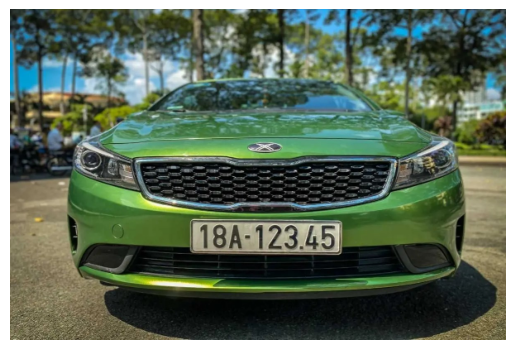

In [84]:
img_path = r"D:\Xu_ly_anh\project\bien_so_xe\data_oto\2.jpg"
img = cv.imread(img_path)
img = cv.resize(img, (600,400))
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()

In [85]:
def gray(img):
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

    H, S, V = cv.split(img_hsv)

    imgTopHat = np.zeros((1920, 1080, 1), np.uint8)
    imgBlackHat = np.zeros((1920, 1080, 1), np.uint8)
    kernel = np.ones((3, 3), np.uint8)

    imgTopHat = cv.morphologyEx(V, cv.MORPH_TOPHAT, kernel, iterations = 10)
    imgBlackHat = cv.morphologyEx(V, cv.MORPH_BLACKHAT, kernel, iterations = 10)

    img_gray = cv.add(V, imgTopHat)
    img_gray = cv.subtract(img_gray, imgBlackHat)
    return img_gray

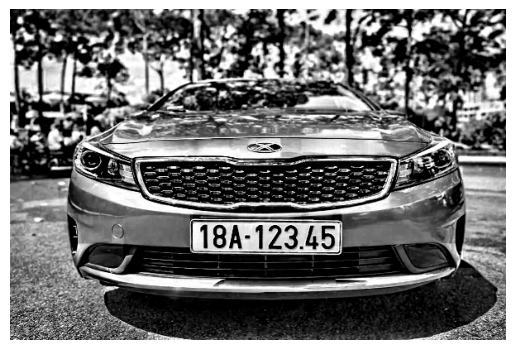

In [86]:
img_gray = gray(img)
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.show()

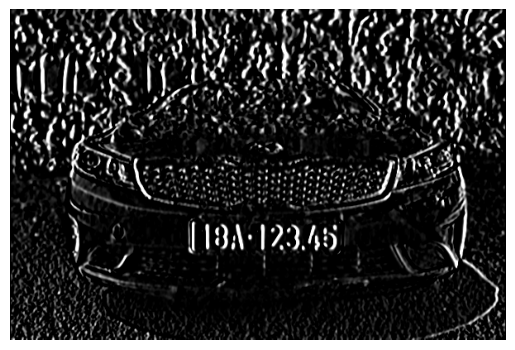

In [87]:
gray_blur = cv.GaussianBlur(img_gray, (5, 5), 0)

img_sobel = cv.Sobel(gray_blur, cv.CV_8U, 1, 0, ksize=3)

plt.imshow(img_sobel, cmap='gray')
plt.axis('off')
plt.show()

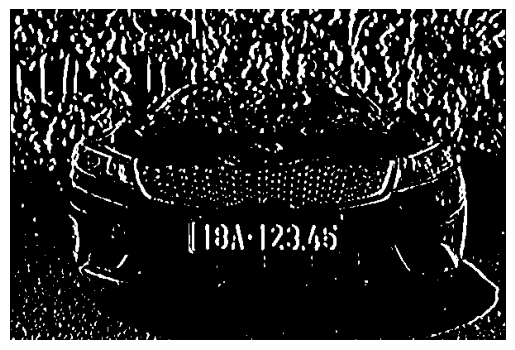

In [88]:
_, img_threshhold = cv.threshold(img_sobel, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

plt.imshow(img_threshhold, cmap='gray')
plt.axis('off')
plt.show()

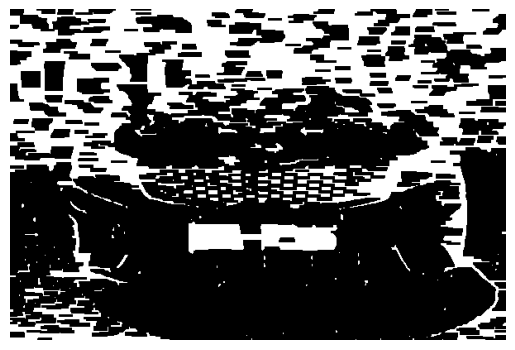

In [89]:
kernel = cv.getStructuringElement(cv.MORPH_RECT, (17, 3))
closing = cv.morphologyEx(img_threshhold, cv.MORPH_CLOSE, kernel)

plt.imshow(closing, cmap='gray')
plt.axis('off')
plt.show()

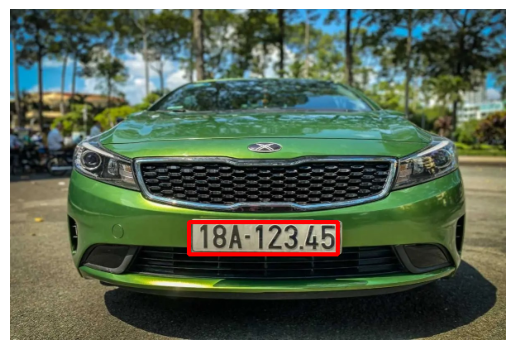

In [90]:
contours, _ = cv.findContours(closing, cv.RETR_EXTERNAL, cv .CHAIN_APPROX_SIMPLE)
new_img = img.copy()

MIN_WIDTH_PX = 100 
MAX_WIDTH_PX = 500
MIN_ASPECT_RATIO = 4

ROI_list = []

for cnt in contours:
    bx, by, bw, bh = cv.boundingRect(cnt)
    if bh >= bw:
        continue

    rect = cv.minAreaRect(cnt)
    (center), (dim1, dim2), angle = rect

    width = max(dim1, dim2)
    height = min(dim1, dim2)

    if height == 0:
        continue

    aspect_ratio = width / height

    if not (MIN_WIDTH_PX <= width <= MAX_WIDTH_PX and 30 < height):
        continue

    if aspect_ratio < MIN_ASPECT_RATIO:
        continue

    x, y, w, h = cv.boundingRect(cnt)
    cv.rectangle(new_img, (x, y), (x + w, y + h), (255, 0, 0), 3)
    roi = img[y : y + h, x : x + w]
    ROI_list.append(roi)

plt.imshow(new_img)
plt.axis('off')
plt.show()

In [91]:
pallete = []
for roi_img in ROI_list:
    roi_img = cv.resize(roi_img, (600,200))

    gray_roi = gray(roi_img)

    kernel = cv.getStructuringElement(cv.MORPH_RECT, (5,5))
    new_roi_img = cv.morphologyEx(gray_roi, cv.MORPH_CLOSE, kernel)
    new_roi_img = cv.morphologyEx(new_roi_img, cv.MORPH_OPEN, kernel)
    new_roi_img = cv.morphologyEx(new_roi_img, cv.MORPH_GRADIENT, kernel)
    _, new_roi_img = cv.threshold(new_roi_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    valid_contours = []
    contours, _ = cv.findContours(new_roi_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    
    for cnt in contours:
        x, y, w, h = cv.boundingRect(cnt)

        # # --- ĐIỀU KIỆN 1: kích thước height của kí tự và width luôn nhỏ hơn height ---
        if not(100 < h < 190 and w < h and w > 20):
            continue

        # # # --- ĐIỀU KIỆN 2: Tỉ lệ aspect  ---
        if not (0.1 < w / float(h) < 0.8):
            continue

        # # --- ĐIỀU KIỆN 3: lọc diện tích thật ---
        if cv.contourArea(cnt) < 1000:
            continue

        valid_contours.append(cnt)
        cv.rectangle(roi_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    valid_contours = sorted(valid_contours, key=cv.contourArea, reverse=True)[:10]
    valid_contours = sorted(valid_contours, key=lambda c: cv.boundingRect(c)[0])


    for cnt in valid_contours:
        x, y, w, h = cv.boundingRect(cnt)
        roi = new_roi_img[y:y+h, x:x+w]
        pallete.append(roi)

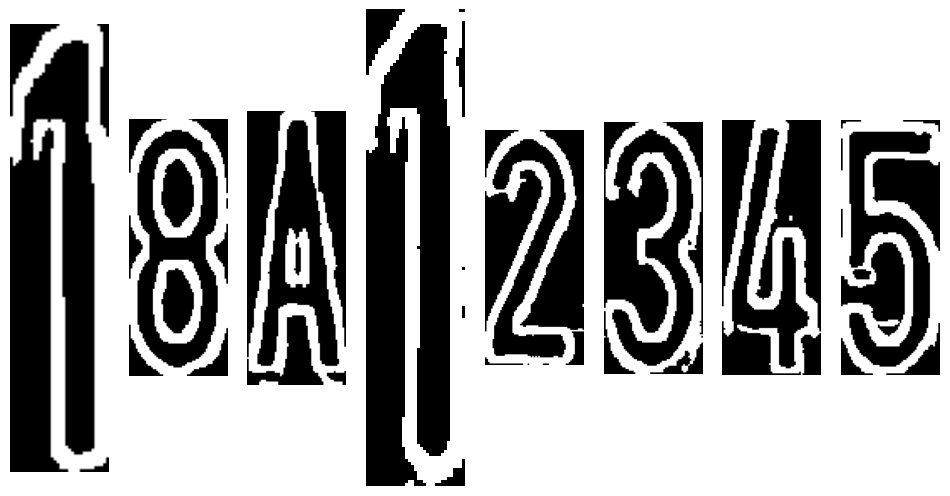

In [92]:
plt.figure(figsize=(12, 8))
for i, cnt in enumerate(pallete):
    plt.subplot(1, len(pallete), i + 1)
    plt.imshow(cnt,cmap='gray')
    plt.axis('off')
plt.show()